In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
plt.style.use("ggplot")


def neg_log_lik(y_pred, y_true, w, mu=0):
    y_pred = y_pred.copy()
    y_pred[y_pred == 0] = 1e-14
    y_pred[y_pred == 1] = 1 - 1e-14
    return -(y_true@np.log(y_pred)) - (1-y_true)@np.log(1-y_pred) + mu*np.sum(np.square(w))

def gradient(X, y_true, y_pred, w, mu=0):
    return ((y_pred - y_true)@X + 2*mu*w)

def sigmoid(wTx):
    return 1/(1+np.exp(-wTx))

def HingeLossl2(C, w, w0, X, y):
    loss = (1/(2*C))*np.dot(w.T,w) + np.sum(np.maximum(0,1-(X@w+w0)*y))
    return loss.squeeze()

def subgradient(C, w, w0, X, y):
    margins = 1-(X@w+w0)*y
    margins = margins.squeeze()
    line0_grad = np.zeros(X.shape)
    hyperplane_grad = (-X*y)
    
    # since line0 grad is a valid option for margin == 0 subgradient
    grad = (
        (1/(2*C))*w  
        + hyperplane_grad[margins>0].sum(axis=0).reshape(-1,1) 
        + line0_grad[margins<=0].sum(axis=0).reshape(-1,1)
    )
    grad0 = np.sum(-y[margins>0])
    grad = grad/np.sqrt(np.sum(grad**2))
    # Return normalized subgradient
    
    return grad0, grad

In [2]:
def AdaGrad(
    X,
    y,
    X_test,
    y_test,
    mu, 
    lr,
    batch_size,
    max_epoch, 
    random_state=3136,
):
    N = X.shape[0]
    m = X.shape[1]
    idx = list(range(N))
    
    n_iter = (N-1)//batch_size + 1
    np.random.seed(random_state)
    w = np.random.rand(m)
    
    y_pred = sigmoid(X @ w)
    print(f"Starting, Loss: {neg_log_lik(y_pred, y, w, mu)}")
    
    lr0 = lr
    sq_grad = np.zeros(m)
    train_losses = []
    test_losses = []
    for epoch in range(max_epoch):
        
        print("="*20, "EPOCH:", epoch, "="*20)
        # Shuffle points at each iteration
        np.random.shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        
        for i in range(n_iter):
            # Get batch
            X_batch = X_shuffled[batch_size*i:batch_size*(i+1),:]
            y_batch = y_shuffled[batch_size*i:batch_size*(i+1)]
            y_pred = sigmoid(X_batch @ w)
            # Get gradient estimate
            g = gradient(X_batch, y_batch, y_pred, w, mu)
            sq_grad += g**2
            update = g/np.sqrt(sq_grad + 1e-10)
            # Update weights
            w = w - lr*update

        lr = lr0*(1/(epoch+1))
        # Report total loss
        y_pred = sigmoid(X @ w)
        g = gradient(X, y, y_pred, w, mu)
        print(f"Train Balanced Acc: {balanced_accuracy_score(y, y_pred>0.5)}")
        print(f"Length gradient: {np.dot(g,g)**0.5}")
        train_loss = neg_log_lik(y_pred, y, w, mu)
        train_losses.append(train_loss)
        test_pred = sigmoid(X_test @ w)
        test_loss = neg_log_lik(test_pred, y_test, w, mu)
        test_losses.append(test_loss)
        
        print(f"Train Loss: {train_loss}")
        print(f"Test Loss: {test_loss}")
        
        
    
    return w, train_losses, test_losses

In [3]:
def AdaSubGradient(
    X,
    y,
    X_test,
    y_test,
    C, 
    lr,
    batch_size,
    max_epoch, 
    random_state=3136,
):
    N = X.shape[0]
    m = X.shape[1]
    idx = list(range(N))
    
    n_iter = (N-1)//batch_size + 1
    np.random.seed(random_state)
    w = np.random.rand(m,1)
    w0 = np.random.rand(1,1)
    
    bacc_y = y.copy()
    bacc_y[bacc_y == -1] = 0
    
    print(f"Starting, Loss: {HingeLossl2(C, w, w0, X, y)}")
    
    lr0 = lr
    sq_grad = np.zeros((m,1))
    sq_grad0 = 0
    train_losses = []
    test_losses = []
    for epoch in range(max_epoch):
        print("="*20, "EPOCH:", epoch, "="*20)
        # Shuffle points at each iteration
        np.random.shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx, :]
        
        for i in range(n_iter):
            # Get batch
            X_batch = X_shuffled[batch_size*i:batch_size*(i+1),:]
            y_batch = y_shuffled[batch_size*i:batch_size*(i+1), :]
            # Get gradient estimate
            g0, g = subgradient(C, w, w0, X_batch, y_batch)
            # Update weights
            sq_grad += g**2
            sq_grad0 += g0**2
            update = g/np.sqrt(sq_grad + 1e-10)
            update0 = g0/np.sqrt(sq_grad0 + 1e-10)
            w = w - lr*update
            w0 = w0 - lr*update0

        lr = lr0*(1/(epoch+1))
        # Report total loss
        y_pred = (X@w + w0) > 0
        train_loss = HingeLossl2(C, w, w0, X, y)
        train_losses.append(train_loss)
        test_loss = HingeLossl2(C, w, w0, X_test, y_test)
        test_losses.append(test_loss)
        print(np.unique(y_pred, return_counts=True))
        print(f"Train Balanced Acc: {balanced_accuracy_score(bacc_y, y_pred)}")
        print(f"Train Loss: {train_loss}")
        print(f"Test Loss: {test_loss}")
    
    return w0 ,w, train_losses, test_losses

In [4]:
pm_data = pd.read_csv("./data/ai4i2020.csv").drop(columns=["TWF", "HDF", "OSF", "RNF", "PWF"])
pm_data = pd.concat([pm_data, pd.get_dummies(pm_data["Type"])], axis=1)
pm_data["intercept"] = 1
feature_names = list(pm_data.drop(columns=["UDI", "Product ID", "Type", "Machine failure"]))
features = pm_data.drop(columns=["UDI", "Product ID", "Type", "Machine failure"]).values
features = MinMaxScaler().fit_transform(features)
target = pm_data["Machine failure"].copy()

(
    X, 
    X_test, 
    y, 
    y_test
)=train_test_split(features, target.values, test_size=0.25, random_state=3136, stratify=target.values)

# Oversample to balance the data
n0 = y.shape[0] - y.sum()
idx1 = np.array(range(y.shape[0]))[(y==1).flatten()]
new_idx = np.random.choice(idx1, size=n0, replace=True)

X = np.concatenate([X[(y == 0).flatten()], X[new_idx]])
y = np.concatenate([y[(y == 0).flatten()], y[new_idx]])

In [5]:
lr, batch_size, max_epoch =  (10, 64, 40)
selected_C = 475.0

y_svm = y.copy()
y_svm[y_svm == 0 ] = -1
y_svm = y_svm.reshape(-1,1)

w0, w, Ltrain, Ltest = AdaSubGradient(
            X=X[:,:-1],
            y=y_svm,
            X_test=X_test[:, :-1],
            y_test=y_test,
            C=selected_C,
            lr=lr,
            batch_size=batch_size,
            max_epoch=max_epoch,
        )

Starting, Loss: 23743.890019340568
==================== EPOCH: 0 ====================
(array([False,  True]), array([ 3753, 10739]))
Train Balanced Acc: 0.723364614959978
Train Loss: 9903.955112247328
Test Loss: 6265368.620540266
==================== EPOCH: 1 ====================
(array([False,  True]), array([4676, 9816]))
Train Balanced Acc: 0.7572453767595915
Train Loss: 8660.195409861555
Test Loss: 6342435.270167893
==================== EPOCH: 2 ====================
(array([False,  True]), array([8291, 6201]))
Train Balanced Acc: 0.8173475020701076
Train Loss: 6512.669532163575
Test Loss: 6604261.486856078
==================== EPOCH: 3 ====================
(array([False,  True]), array([5779, 8713]))
Train Balanced Acc: 0.8116892078388076
Train Loss: 6731.122903173416
Test Loss: 6419462.168113165
==================== EPOCH: 4 ====================
(array([False,  True]), array([5770, 8722]))
Train Balanced Acc: 0.8045818382555894
Train Loss: 6810.346550892574
Test Loss: 6411529.8348

In [6]:
Ltrain = np.stack(Ltrain)
Ltest = np.stack(Ltest)

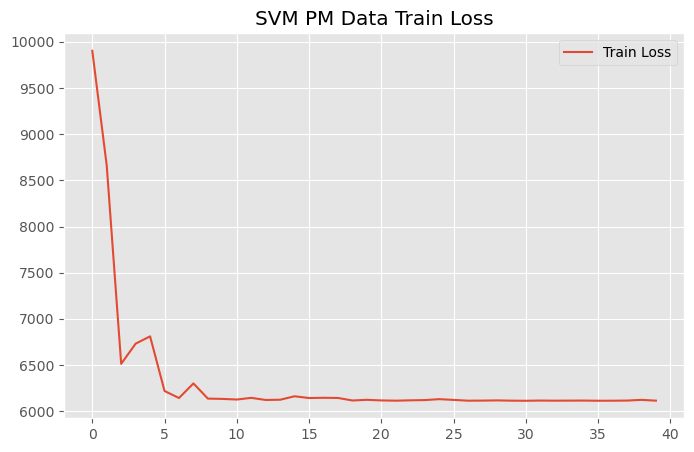

In [7]:
x_axis = list(range(max_epoch))
plt.figure(figsize=(8,5))
plt.plot(x_axis, Ltrain, label="Train Loss")
plt.title("SVM PM Data Train Loss")
plt.legend()
plt.show()

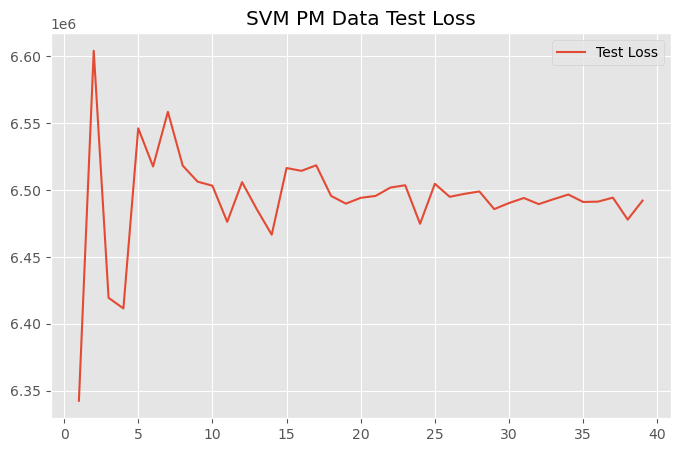

In [8]:
plt.figure(figsize=(8,5))
plt.plot(x_axis[1:], Ltest[1:], label="Test Loss")
plt.title("SVM PM Data Test Loss")
plt.legend()
plt.show()

In [12]:
lr, batch_size, max_epoch =  (10, 64, 40)
selected_mu = 0

w, Ltrain, Ltest = AdaGrad(
            X=X,
            y=y,
            X_test=X_test,
            y_test=y_test,
            mu=selected_mu,
            lr=lr,
            batch_size=batch_size,
            max_epoch=max_epoch,
        )

Starting, Loss: 17539.565031706417
==================== EPOCH: 0 ====================
Train Balanced Acc: 0.8089290643113441
Length gradient: 828.8984577655875
Train Loss: 6292.687993074564
Test Loss: 1289.8174657527788
==================== EPOCH: 1 ====================
Train Balanced Acc: 0.8148633728953906
Length gradient: 605.6651186260744
Train Loss: 5922.756535862396
Test Loss: 1151.4379046937559
==================== EPOCH: 2 ====================
Train Balanced Acc: 0.8273530223571626
Length gradient: 472.4019355323607
Train Loss: 5844.694672412148
Test Loss: 902.6929740633482
==================== EPOCH: 3 ====================
Train Balanced Acc: 0.8160364338945625
Length gradient: 198.03358622246282
Train Loss: 5788.731336924932
Test Loss: 1038.6555809630597
==================== EPOCH: 4 ====================
Train Balanced Acc: 0.8205906707148771
Length gradient: 445.8196239592761
Train Loss: 5799.985475770658
Test Loss: 1094.9734758601296
==================== EPOCH: 5 ==========

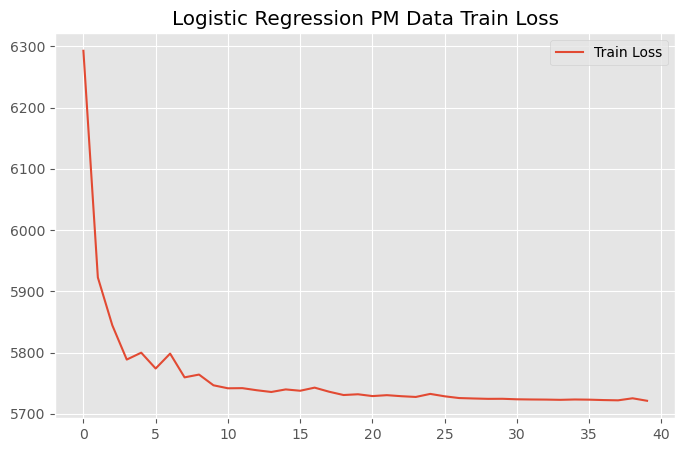

In [13]:
plt.figure(figsize=(8,5))
plt.plot(x_axis, Ltrain, label="Train Loss")
plt.title("Logistic Regression PM Data Train Loss")
plt.legend()
plt.show()

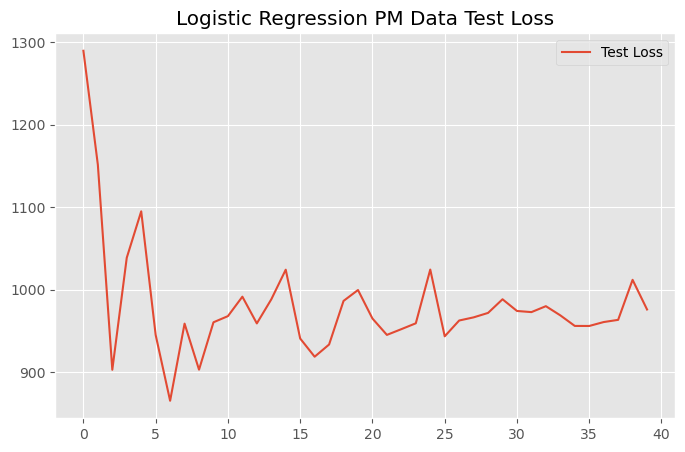

In [14]:
plt.figure(figsize=(8,5))
plt.plot(x_axis, Ltest, label="Test Loss")
plt.title("Logistic Regression PM Data Test Loss")
plt.legend()
plt.show()